## 1D Terzaghi Consolidation Problem (PINN)

In [1]:
import numpy as np 
import sciann as sn
import matplotlib.pyplot as plt

import pandas as pd
import subprocess

from scianndatagen import DataGeneratorXT
from sciann.utils.math import sign, abs, sigmoid, tanh, diff

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.0 
Python Version: 3.9.19 (main, May  6 2024, 20:12:36) [MSC v.1916 64 bit (AMD64)] 



In [2]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

In [3]:
# ----------------------- Constant Parameters -------------------------
cv = 1.0
Ly = 2*m
p0 = 1.0
p_star = 1.0

y_min, y_max = 0.,Ly
t_min, t_max = 0.,1.0

NUM_SAMPLES = 10000

In [4]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(1234)

yd = sn.Variable('yd', dtype='float32')
td = sn.Variable('td', dtype='float32')

pd = sn.Functional('pd', [yd, td], 8*[20], 'tanh')

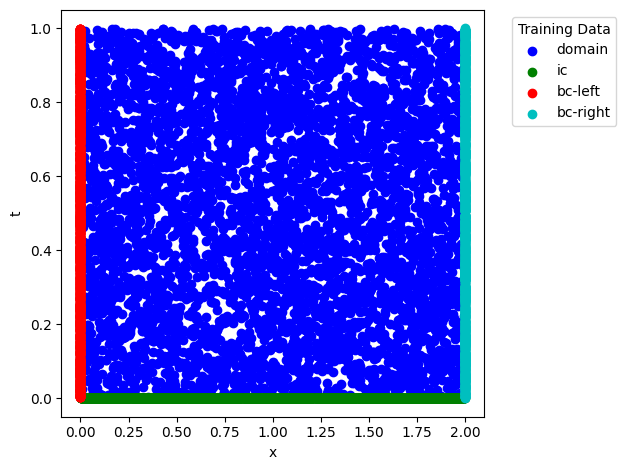

In [5]:
# Generate the training data
dg = DataGeneratorXT(
    X=[y_min, y_max],
    T=[t_min, t_max],
    targets=['domain', 'ic', 'bc-left', 'bc-right'],
    num_sample=NUM_SAMPLES,
)
dg.plot_data()

In [6]:
pd_y = diff(pd, yd)
pd_yy = diff(pd_y, yd)
pd_t = diff(pd, td)

# PDE Equation and BCs
PDE_1D = cv*pd_yy - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_bot = (yd == y_min) * abs(pd)
bc_top = (yd == y_max) * abs(pd)

targets_1D = [sn.PDE(PDE_1D), bc_ini, bc_bot, bc_top]

input_data_1D, target_data_1D = dg.get_data()

In [7]:
adaptive_weights = {'method': 'NTK', 'freq':200}
epochs = 250
batch_size = 500
initial_lr = 1e-3
final_lr = initial_lr/10

learning_rate = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": epochs
}

In [9]:
train = False
load_weights = not train

# Create and train the model
model = sn.SciModel(
    [yd, td],
    targets_1D,
    "mse",
    "Adam",
    load_weights_from = 'Terzaghi_1D_100k.hdf5' if load_weights else None 
)

if train:
    global H
    H = model.train(
        input_data_1D,
        target_data_1D,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        stop_loss_value=1e-8,
        stop_after=None,
        verbose=2,
        adaptive_weights=adaptive_weights
    )
    model.save_weights('Terzaghi1D_trained_weights.hdf5')

In [10]:
if train:
    # Loss output
    loss = H.history["loss"]
    learning_rate = H.history["lr"]

    def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
        if X is None:
            im = AX.semilogy(Y)
        else:
            im = AX.semilogy(X, Y)
        if xlabel is not None: AX.set_xlabel(xlabel)
        if ylabel is not None: AX.set_ylabel(ylabel)
        if title is not None: AX.set_title(title)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
    cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Epochs_1D.png',dpi=600)
    plt.show()

In [11]:
# Define the evaluation grid
N = 100

zs = np.linspace(y_min, y_max, N * 3)  # Depth (y-axis)
ts = np.linspace(t_min, t_max, N * 3)  # Time (x-axis)

Ztest, Ttest = np.meshgrid(zs, ts, indexing='ij')
input_test = [Ztest, Ttest]

zs_line_plot = np.linspace(y_min, y_max, N * 3)
ts_line_plot = np.array([t_max*0.01, t_max * 0.1, t_max * 0.3, t_max * 0.5, t_max * 0.7, t_max * 0.9])
input_test_line_plot = np.meshgrid(zs_line_plot, ts_line_plot, indexing='ij')

# Evaluate Model Predictions
p_pred_contour = pd.eval([input_test[0].flatten(), input_test[1].flatten()]).reshape(input_test[0].shape)
p_pred_line = pd.eval([input_test_line_plot[0].flatten(), input_test_line_plot[1].flatten()]).reshape(input_test_line_plot[0].shape)

### Exact and PINN Solutions

Terzaghi's one-dimensional consolidation equation is:

$\qquad c_v\frac{\partial^2 u}{\partial z^2} = \frac{\partial u}{\partial t}$

The solution to this equation is obtained by separation of variables and a Fourier series to be:

$\qquad U_z = 1 - \sum_{n=1}^{\infty}\frac{4}{\pi n}sin^2\left(\frac{\pi n}{2}\right)sin\left(\frac{\pi n Z}{2}\right)e^{-\frac{Tn^2\pi^2}{4}}$

$\qquad$ where $U_z = 1 - \frac{u_e}{\Delta\sigma_v}$, $T = \frac{c_v t}{H^2}$, $Z = \frac{z}{H}$, $z$ is depth, and $H$ is drainage path length.

Of course, we can't actually perform this sum from 1 to $\infty$, so we have to select a suitable number of terms in the Fourier series, N, to obtain an accurate solution:

$\qquad U_z \approx 1 - \sum_{n=1}^{N}\frac{4}{\pi n}sin^2\left(\frac{\pi n}{2}\right)sin\left(\frac{\pi n Z}{2}\right)e^{-\frac{Tn^2\pi^2}{4}}$

Notice that the $sin^2\left(\frac{\pi n}{2}\right)$ term is equal to 0 for even n, and 1 for odd n. I have summed only over odd values of n to make the code faster.

In [12]:
def Uz(N,Z,T):
    uz = 0
    #function is zero for even values of n. Therefore only compute for odd values
    for n in range(1,N+1,2):
        uz += 4.0/np.pi/n*np.sin(np.pi*n/2.0*Z)*np.exp(-1.0*n*n*np.pi*np.pi/4.0*T)
    return uz

cv = 1.0 # consolidation m^2/year
H = Ly/2 # drainage path length
t = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
T = (cv*np.array(t))/H**2
Z = zs
N = 50

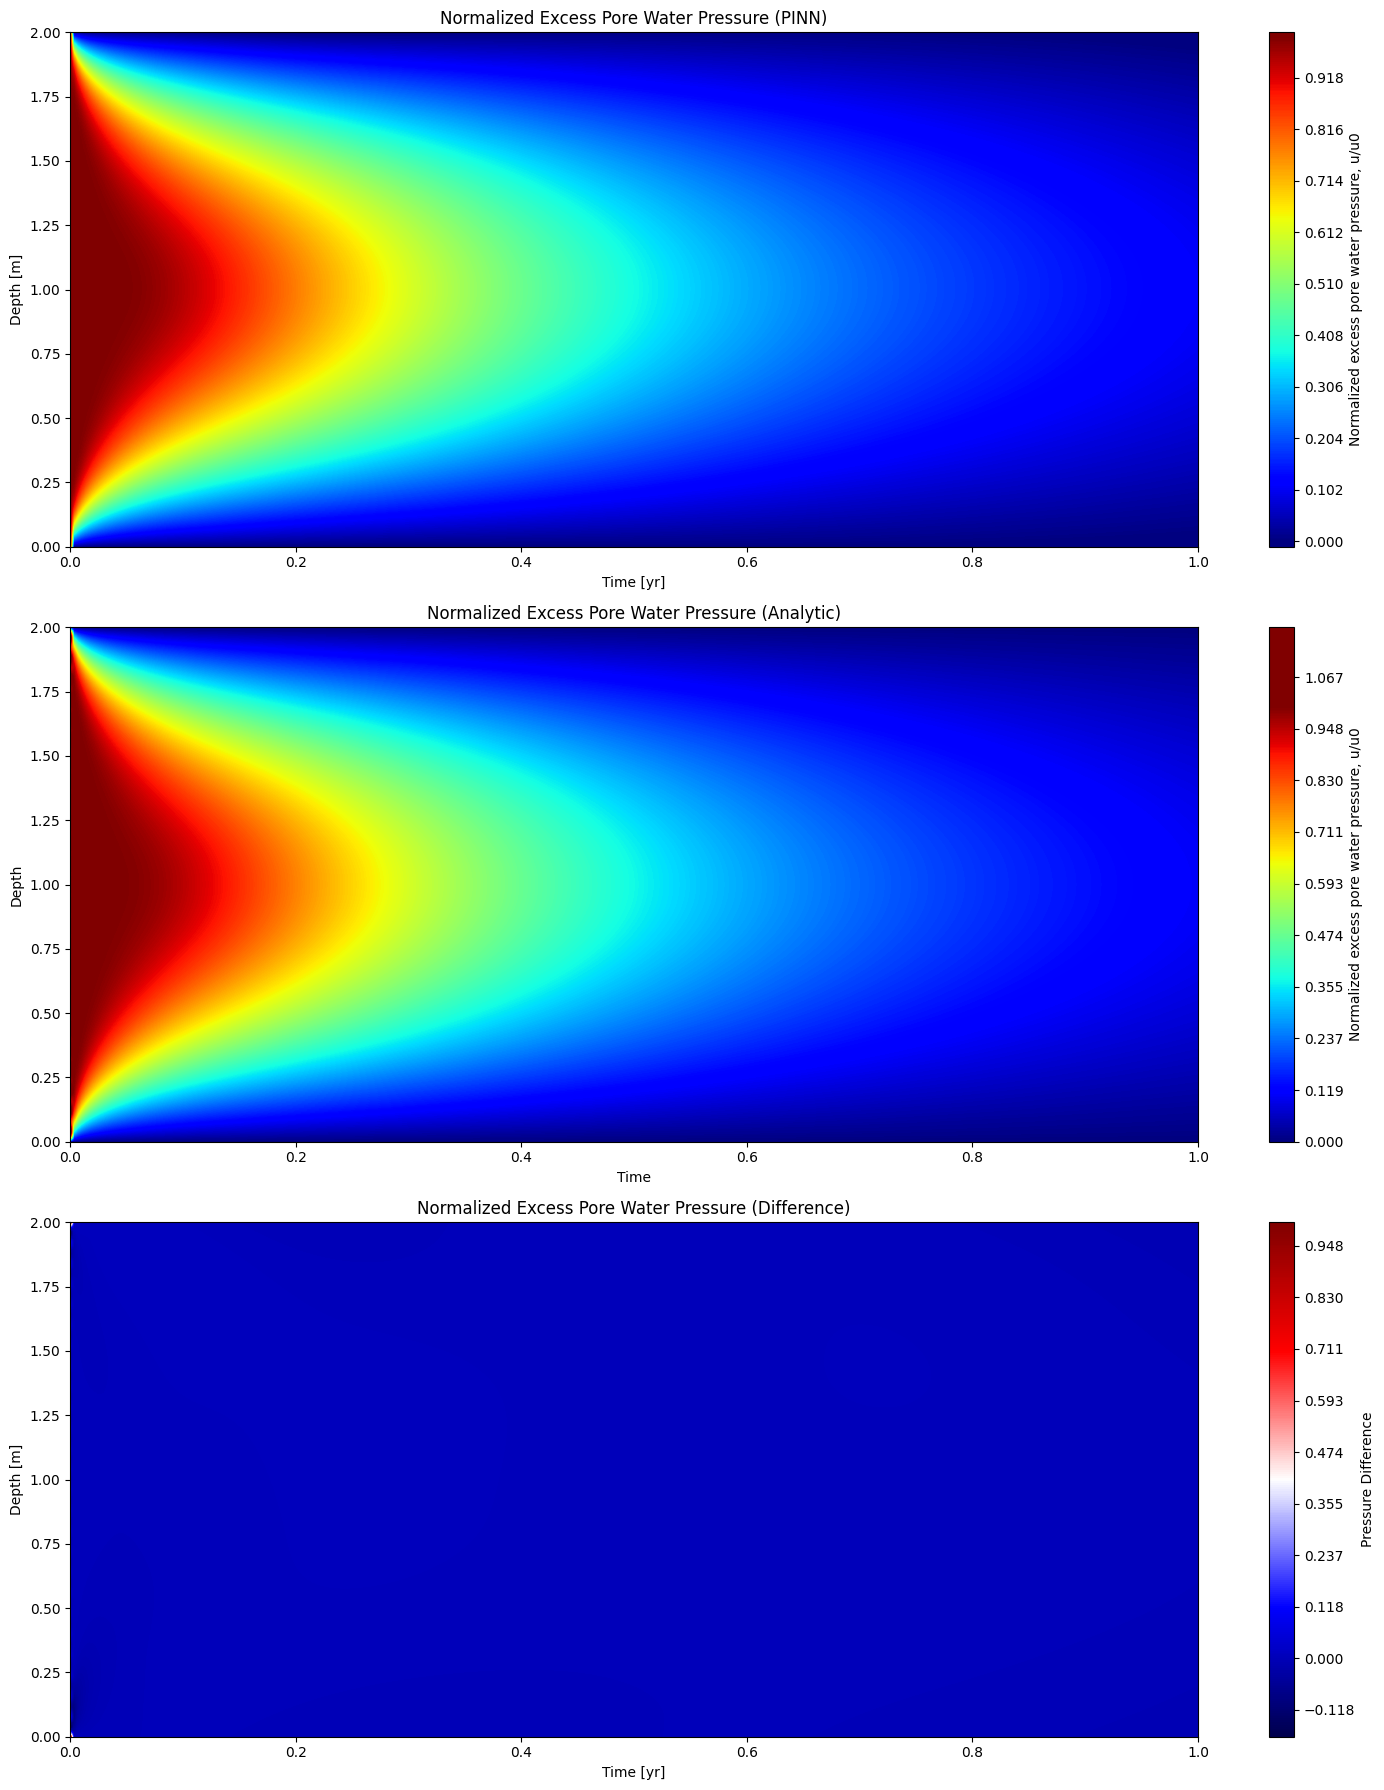

In [31]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 18))

# Plot 1: Contour plot for predicted pressure
c0 = axs[0].contourf(Ttest, Ztest, p_pred_contour, levels=1000, cmap='jet', vmin=0, vmax=1)
fig.colorbar(c0, ax=axs[0], label='Normalized excess pore water pressure, u/u0')
axs[0].set_title('Normalized Excess Pore Water Pressure (PINN)')
axs[0].set_xlabel('Time [yr]')
axs[0].set_ylabel('Depth [m]')
axs[0].invert_yaxis()  # Invert y-axis to match the depth orientation
axs[0].set_xlim(t_min, t_max)
axs[0].set_ylim(y_min, y_max)

# Parameters for the contour plot
time = ts
depth = zs
T_contour = np.array([[cv * t / (H**2) for t in time] for z in depth])

# Create the meshgrid for contour plot using 'ij' indexing
T_mesh, Z_mesh = np.meshgrid(time, depth, indexing='ij')
U_mesh = np.zeros_like(T_mesh)

# Calculate the analytical pressures
for i in range(len(time)):
    for j in range(len(depth)):
        U_mesh[i, j] = Uz(N, Z_mesh[i, j], T_contour[j, i])

# Plot 2: Contour plot for analytical pressure
contour = axs[1].contourf(T_mesh, Z_mesh, U_mesh, levels=1000, cmap='jet', vmin=0., vmax=1)
fig.colorbar(contour, ax=axs[1], label='Normalized excess pore water pressure, u/u0')
axs[1].set_title('Normalized Excess Pore Water Pressure (Analytic)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Depth')

# Calculate the difference between predicted and analytical pressures
pressure_difference = p_pred_contour - U_mesh.T

# Plot 3: Contour plot for pressure difference
contour_diff = axs[2].contourf(Ttest, Ztest, pressure_difference, levels=1000, cmap='seismic')
fig.colorbar(contour_diff, ax=axs[2], label='Pressure Difference')
axs[2].set_title('Normalized Excess Pore Water Pressure (Difference)')
axs[2].set_xlabel('Time [yr]')
axs[2].set_ylabel('Depth [m]')
axs[2].invert_yaxis()  # Invert y-axis to match the depth orientation
axs[2].set_xlim(t_min, t_max)
axs[2].set_ylim(y_min, y_max)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("1D-ContourComparison.png", dpi=600)
plt.show()

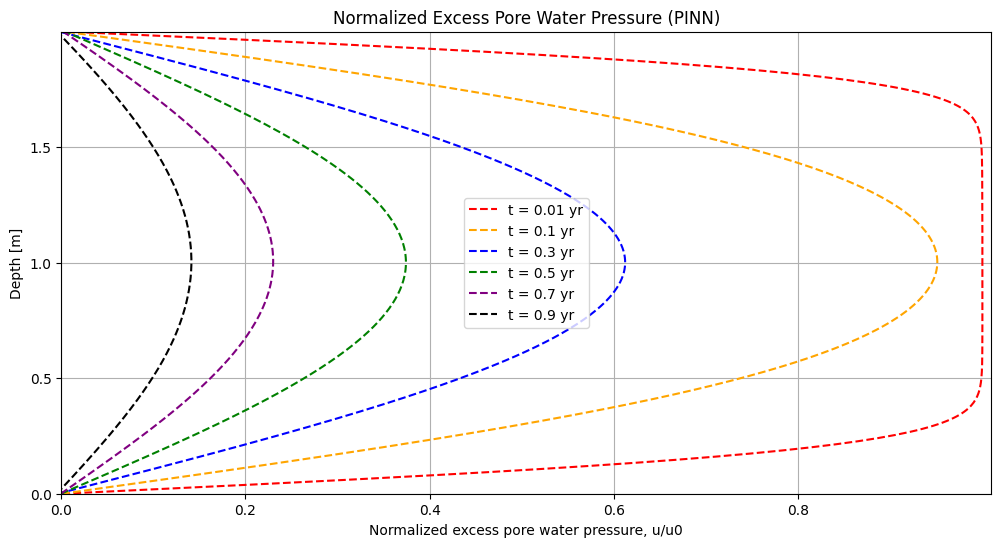

In [14]:
# Plot settings
legend_settings = {
    'bbox_to_anchor': (1.25, 0.25),
    'loc': 'upper left',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False
}

# Define time steps for plotting
ts_line_plot = np.array([0.01, 0.1, 0.3, 0.5, 0.7, 0.9])  # Time steps

# Plot settings
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
line_colors = ['red', 'orange', 'blue', 'green', 'purple', 'black']  # Ensure this matches the number of time steps

# Plot predicted lines for the specified time steps
for i, time_step in enumerate(ts_line_plot):
    time_plot = np.around(time_step, decimals=2)
    ax.plot(p_pred_line[:, i]/p0, zs_line_plot, color=line_colors[i], linestyle='--', label=f't = {time_plot} yr')

# Setting labels and titles
ax.set_xlabel('Normalized excess pore water pressure, u/u0')
ax.set_ylabel('Depth [m]')
ax.set_title('Normalized Excess Pore Water Pressure (PINN)')
ax.legend(loc='best')
ax.grid(True)

# Plot limits
plt.xlim(0, 1.01)
plt.ylim(0, Ly)
plt.xticks(np.arange(0, 1., 0.2))
plt.yticks(np.arange(0, Ly, 0.5))

plt.savefig("PressureWithTime-1D.png", dpi=600)
plt.show()

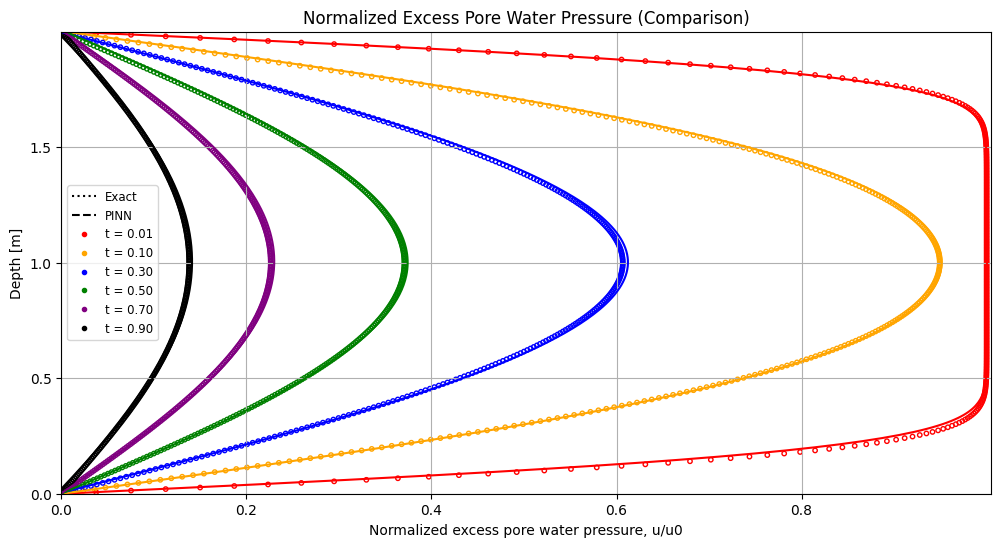

In [26]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlabel('Normalized excess pore water pressure, u/u0')
ax.set_ylabel('Depth [m]')
ax.set_title('Normalized Excess Pore Water Pressure (Comparison)')
ax.set_xlim(0., 1.0)
ax.set_ylim(0, Ly)

# Plot analytical solution
for idx, t_val in enumerate(T):
    u = []
    for z in Z:
        u.append(Uz(N, z, t_val))
    plt.scatter(u, Z, color=line_colors[idx], marker='o', facecolors='none', label=f't = {t[idx]:.2f}', s=10)  # Adjust s for point size

# Plot predicted lines for the specified time steps
for i, time_step in enumerate(t):
    time_plot = np.around(time_step, decimals=2)
    ax.plot(p_pred_line[:, i] / p0, zs_line_plot, color=line_colors[i], linestyle='-')

plt.grid(True)

# Custom legend
legend_elements = [Line2D([0], [0], color='black', linestyle=':', label='Exact'),
                   Line2D([0], [0], color='black', linestyle='--', label='PINN')]

# Add t=timepoint labels to the legend
for idx, time_step in enumerate(t):
    legend_elements.append(Line2D([0], [0], color=line_colors[idx], marker='.', linestyle='None', label=f't = {time_step:.2f}'))

ax.legend(handles=legend_elements, loc='best', fontsize=8.5)

# Plot limits
plt.xlim(0, 1.005)
plt.ylim(0, Ly)
plt.xticks(np.arange(0, 1., 0.2))
plt.yticks(np.arange(0, 2., 0.5))

plt.savefig("PressureWithTime.png", dpi=600)
plt.show()